# Anomaly detection 3

In this notebook we are going to perform anomaly detection on the dataset data_clean.xlsx using : Seasonal trend decomposition using LOESS (STL). We are going to study each meterId as a separate time series, decompose it to its seasonal and trend components and extract the residue. The points where the residue is too big (more than 3 standard deviations away from the mean) suggest an anomaly.

In [1]:
## Importing necessary libraries

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.seasonal import STL

In [2]:
#Load data

file_name = ".\\data_clean.xlsx"
xl_file = pd.ExcelFile(file_name,engine = 'openpyxl')
df = xl_file.parse('Sheet1')

## Data Preprocessing

In [3]:
# Null values 
df.dropna(subset=['data'], inplace=True)
df = df.reset_index(drop=True)

##Handling units
# We are going to convert everything that is MWh to KWh and  Nm³ , CCF , l, kl to m³

df['unit']=df['unit'].astype('string')

#df2 = df
#print(len(df2[df2['unit']=='MWh']))
for i, row in df.iterrows():
    # 1MWh = 1000KWh
    if row['unit'] == 'MWh':
        df.at[i, 'data'] = row['data']*1000
        df.at[i, 'unit'] = 'kWh'

    #we will consider that we work in stadard condition (T=273.15K et P=101325 Pa) and 1Nm³ = 1m³
    if row['unit'] == 'Nm³':
        df.at[i, 'unit'] = 'm³'

    # 1CCF = 2,83m³
    if row['unit'] == 'CCF':
        df.at[i, 'data'] = row['data']*2.83
        df.at[i, 'unit'] = 'm³'    

    # 1l = 0.001m³
    if row['unit'] == 'l':
        df.at[i, 'data'] = row['data']*0.001
        df.at[i, 'unit'] = 'm³'

    #1kl = 1m³
    if row['unit'] == 'kl':
        df.at[i, 'unit'] = 'm³'

    #1ft³ = 0,0283m³
    if row['unit'] == 'ft³':
        df.at[i, 'data'] = row['data']*0.0283
        df.at[i, 'unit'] = 'm³'

    #1therm = 2,851m³
    if row['unit'] == 'therm':
        df.at[i, 'data'] = row['data']*2.851
        df.at[i, 'unit'] = 'm³'


## Visualizing data as time series

- In this section you can specify a meterId and visualize its corresponding time series as well as the decomposition of the time series to its component (seasonal, trend, residual), you can also see the process of detecting anomalies
- The anomaly detections is performed in the section that follows

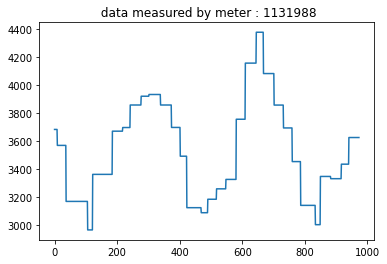

In [6]:
## specify meterId and visualize data

meterIds = list(df.meterId.unique())

mId = meterIds[0]

df_temp = df[df['meterId']==mId]

plt.plot(df_temp['data'])
plt.title (' data measured by meter : ' + str(mId))
plt.show()

In [7]:
## Performing stl on specified meterId

data = df_temp['data']
data.index = [i for i in range(data.shape[0])]
stl = STL(data,period = 12)
result = stl.fit()

In [8]:
seasonal, trend, resid = result.seasonal, result.trend, result.resid

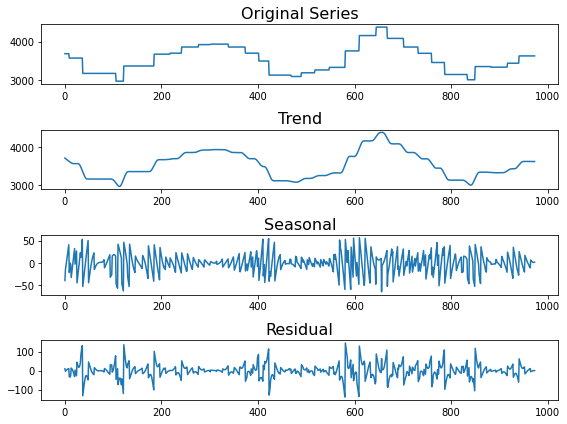

In [9]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(data)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

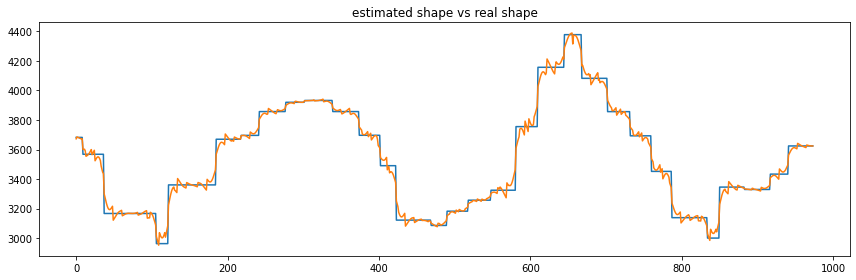

In [12]:
## Visualize estimated shape vs real shape
estimated = trend + seasonal
plt.figure(figsize=(12,4))
plt.plot(data)
plt.plot(estimated)
plt.title('estimated shape vs real shape')
plt.tight_layout()

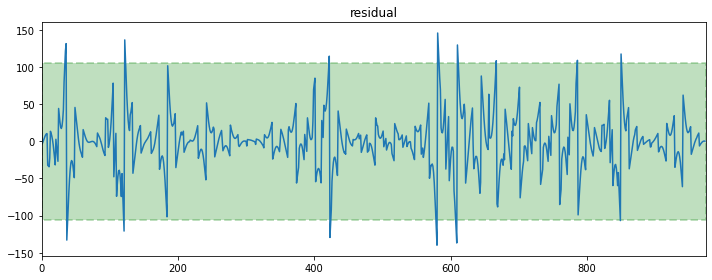

In [13]:
## The residual of the time series

import datetime
from datetime import datetime
resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

plt.figure(figsize=(10,4))
plt.plot(resid)

plt.fill_between([0, len(data)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(0, len(data))
plt.title('residual')
plt.tight_layout()

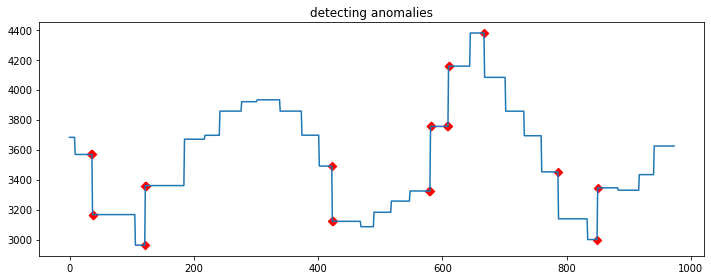

In [14]:
## Visualizing the anomalies

anomalies = data[(resid < lower) | (resid > upper)]
plt.figure(figsize=(10,4))
plt.plot(data)
# for year in range(2004,2021):
#     plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)
    
plt.scatter(anomalies.index, anomalies.values, color='r', marker='D')
plt.title('detecting anomalies')
plt.tight_layout()

## Performing Anomaly detection on the dataset using STL

In [16]:
##Performing anomaly detection

meterIds = list(df.meterId.unique())
all_anomalies_idx = []

for mId in meterIds :
    df_temp = df[df['meterId']==mId]

    data = df_temp['data']
    data.index = [i for i in range(data.shape[0])]
    stl = STL(data,period = 12)
    result = stl.fit()
    seasonal, trend, resid = result.seasonal, result.trend, result.resid
    estimated = trend + seasonal
    resid_mu = resid.mean()
    resid_dev = resid.std()

    lower = resid_mu - 3*resid_dev
    upper = resid_mu + 3*resid_dev
    
    idx = df_temp.index
    
    for i in range(len(resid)):
        if (resid[i] < lower) | (resid[i] > upper) :
            all_anomalies_idx.append(idx[i])

all_anomalies = df.iloc[all_anomalies_idx]

In [18]:
print('the percentage of total : ',round(len(all_anomalies)/len(df)*100,2),' %')

the percentage of total :  1.41  %


In [19]:
## Choose mediaType

mediaType = 'Electricity'
df_temp = df[df['mediaType']==mediaType]
temp = all_anomalies[all_anomalies['mediaType']==mediaType]
print('locations with anomalies and their percentage : \n')
print(temp['Location_'].value_counts().index,'\n')
print(np.round(temp['Location_'].value_counts().to_numpy()*100,2)/len(temp))

locations with anomalies and their percentage : 

Index(['India kalwa', 'Austria', 'Switzerland Zug', 'United State HU',
       'Portugal', 'United State DA', 'Germany', 'United State SQ',
       'United State FH', 'United State HE', 'India GU', 'Switzerland SH',
       'United State BE', 'United State LA', 'United State JS', 'Netherland',
       'China', 'United State PO', 'Singapour', 'India JI', 'India BAN'],
      dtype='object') 

[31.38943249 26.45792564 15.14677104  5.47945205  5.04892368  2.77886497
  1.83953033  1.60469667  1.48727984  1.40900196  1.21330724  1.01761252
  0.86105675  0.82191781  0.78277886  0.78277886  0.58708415  0.58708415
  0.31311155  0.23483366  0.15655577]


In [20]:
print('the percentage of anomalies in this mediaType : ',round((len(temp)/len(df_temp))*100,2),' %')

the percentage of anomalies in this mediaType :  1.38  %


In [21]:
print('the number of meterIds : ',temp.meterId.nunique())

the number of meterIds :  204


In [22]:
print("****The anomalies in this mediaType****\n")
temp

****The anomalies in this mediaType****



,date,meterId,Country,mediaType,data,unit,Location_,meterType
35,2019-11-05,1131988,Austria,Electricity,3567.86,kWh,Austria,Submeter
36,2019-11-06,1131988,Austria,Electricity,3567.86,kWh,Austria,Submeter
37,2019-11-07,1131988,Austria,Electricity,3166.67,kWh,Austria,Submeter
38,2019-11-08,1131988,Austria,Electricity,3166.67,kWh,Austria,Submeter
121,2020-01-30,1131988,Austria,Electricity,2962.50,kWh,Austria,Submeter
...,...,...,...,...,...,...,...,...
289714,2021-11-02,980329,Netherlands,Electricity,52.57,kWh,Netherland,Sub 2
289832,2022-02-28,980329,Netherlands,Electricity,57.82,kWh,Netherland,Sub 2
289833,2022-03-01,980329,Netherlands,Electricity,57.82,kWh,Netherland,Sub 2
289834,2022-03-02,980329,Netherlands,Electricity,66.19,kWh,Netherland,Sub 2
